# Event classification for payment card fraud detection using Temporian library for features

In [1]:
%pip install temporian

In [2]:
%pip install pandas==1.3.0

  Using cached pandas-1.3.0.tar.gz (4.7 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
import keras  # To train the Machine Learning model
import temporian as tp  # To convert transactions into tabular data

import numpy as np
import os
import pandas as pd
import datetime
import math
import tensorflow as tf
from sklearn.metrics import RocCurveDisplay

## Introduction

Payment fraud detection is critical for banks, businesses, and consumers. In
Europe alone, fraudulent transactions were estimated at
[€1.89 billion in 2019](https://www.ecb.europa.eu/pub/pdf/cardfraud/ecb.cardfraudreport202110~cac4c418e8.en.pdf).
Worldwide, approximately
[3.6%](https://www.cybersource.com/content/dam/documents/campaign/fraud-report/global-fraud-report-2022.pdf)
of commerce revenue is lost to fraud. In this notebook, we train and evaluate a
model to detect fraudulent transactions using the synthetic dataset attached to
the book
[Reproducible Machine Learning for Credit Card Fraud Detection](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html)
by Le Borgne et al.

Fraudulent transactions often cannot be detected by looking at transactions in
isolation. Instead, fraudulent transactions are detected by looking at patterns
across multiple transactions from the same user, to the same merchant, or with
other types of relationships. To express these relationships in a way that is
understandable by a machine learning model, and to augment features with feature
 engineering, we We use the
 [Temporian](https://temporian.readthedocs.io/en/latest) preprocessing library.

We preprocess a transaction dataset into a tabular dataset and use a
feed-forward neural network to learn the patterns of fraud and make predictions.

## Loading the dataset

The dataset contains payment transactions sampled between April 1, 2018 and
September 30, 2018. The transactions are stored in CSV files, one for each day.

**Note:** Downloading the dataset takes ~1 minute.

In [4]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 9, 30)

# Load the dataset as a Pandas dataframe.
cache_path = "fraud_detection_cache.csv"
if not os.path.exists(cache_path):
    print("Download dataset")
    dataframes = []
    num_files = (end_date - start_date).days
    counter = 0
    while start_date <= end_date:
        if counter % (num_files // 10) == 0:
            print(f"[{100 * (counter+1) // num_files}%]", end="", flush=True)
        print(".", end="", flush=True)
        url = f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/6e67dbd0a3bfe0d7ec33abc4bce5f37cd4ff0d6a/data/{start_date}.pkl"
        dataframes.append(pd.read_pickle(url))
        start_date += datetime.timedelta(days=1)
        counter += 1
    print("done", flush=True)
    transactions_dataframe = pd.concat(dataframes)
    transactions_dataframe.to_csv(cache_path, index=False)
else:
    print("Load dataset from cache")
    transactions_dataframe = pd.read_csv(
        cache_path, dtype={"CUSTOMER_ID": bytes, "TERMINAL_ID": bytes}
    )

print(f"Found {len(transactions_dataframe)} transactions")

Download dataset
[0%]..................[10%]..................[20%]..................[30%]..................[40%]..................[50%]..................[59%]..................[69%]..................[79%]..................[89%]..................[99%]...done
Found 1754155 transactions


In [5]:
transactions_dataframe = transactions_dataframe[
    ["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]
]

transactions_dataframe.head(4)

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,2018-04-01 00:00:31,596,3156,57.16,0
1,2018-04-01 00:02:10,4961,3412,81.51,0
2,2018-04-01 00:07:56,2,1365,146.00,0
3,2018-04-01 00:09:29,4128,8737,64.49,0


from matplotlib import pyplot as plt
_df_0['TX_AMOUNT'].plot(kind='hist', bins=20, title='TX_AMOUNT')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('CUSTOMER_ID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('TERMINAL_ID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TX_DATETIME']
  ys = series['TX_AMOUNT']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('TX_DATETIME', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CUSTOMER_ID')):
  _plot_series(series, series_name, i)
  fig.legend(title='CUSTOMER_ID', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TX_DATETIME')
_ = plt.ylabel('TX_AMOUNT')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TX_DATETIME']
  ys = series['TX_AMOUNT']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('TX_DATETIME', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('TERMINAL_ID')):
  _plot_series(series, series_name, i)
  fig.legend(title='TERMINAL_ID', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TX_DATETIME')
_ = plt.ylabel('TX_AMOUNT')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['TX_DATETIME']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TX_DATETIME'}, axis=1)
              .sort_values('TX_DATETIME', ascending=True))
  xs = counted['TX_DATETIME']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('TX_DATETIME', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CUSTOMER_ID')):
  _plot_series(series, series_name, i)
  fig.legend(title='CUSTOMER_ID', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TX_DATETIME')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['TX_DATETIME']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TX_DATETIME'}, axis=1)
              .sort_values('TX_DATETIME', ascending=True))
  xs = counted['TX_DATETIME']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('TX_DATETIME', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('TERMINAL_ID')):
  _plot_series(series, series_name, i)
  fig.legend(title='TERMINAL_ID', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TX_DATETIME')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['TX_AMOUNT'].plot(kind='line', figsize=(8, 4), title='TX_AMOUNT')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['TERMINAL_ID'].value_counts()
    for x_label, grp in _df_8.groupby('CUSTOMER_ID')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CUSTOMER_ID')
_ = plt.ylabel('TERMINAL_ID')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['CUSTOMER_ID'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='TX_AMOUNT', y='CUSTOMER_ID', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['TERMINAL_ID'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='TX_AMOUNT', y='TERMINAL_ID', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [6]:
# This is a highly imbalanced dataset
fraudulent_rate = transactions_dataframe["TX_FRAUD"].mean()
print("Rate of fraudulent transactions:", fraudulent_rate)

Rate of fraudulent transactions: 0.008369271814634397


The pandas dataframe is converted into a Temporian EventSet, which is better suited for the data exploration and feature preprocessing of the next steps.

In [7]:
transactions_evset = tp.from_pandas(transactions_dataframe, timestamps="TX_DATETIME")

transactions_evset

timestamp,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
2018-04-01 00:00:31+00:00,596,3156,57.16,0
2018-04-01 00:02:10+00:00,4961,3412,81.51,0
2018-04-01 00:07:56+00:00,2,1365,146,0
2018-04-01 00:09:29+00:00,4128,8737,64.49,0
2018-04-01 00:10:34+00:00,927,9906,50.99,0
…,…,…,…,…


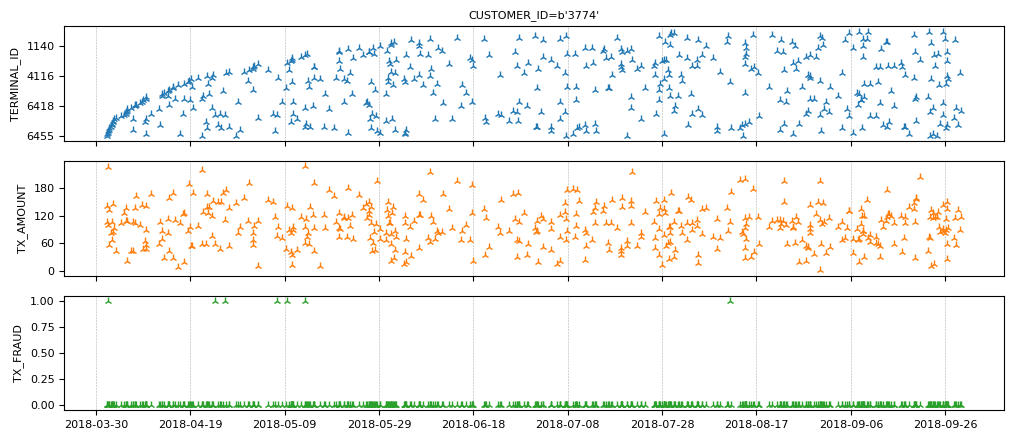

In [8]:
transactions_evset.add_index("CUSTOMER_ID").plot(indexes="3774")

In [9]:
# Group the transactions per terminal
transactions_per_terminal = transactions_evset.add_index("TERMINAL_ID")

# Moving statistics per terminal
tmp_features = []
for n in [7, 14, 28]:
    tmp_features.append(
        transactions_per_terminal["TX_AMOUNT"]
        .moving_sum(tp.duration.days(n))
        .rename(f"sum_transactions_{n}_days")
    )

    tmp_features.append(
        transactions_per_terminal.moving_count(tp.duration.days(n)).rename(
            f"count_transactions_{n}_days"
        )
    )

feature_set_1 = tp.glue(*tmp_features)

feature_set_1

timestamp,sum_transactions_7_days,count_transactions_7_days,sum_transactions_14_days,count_transactions_14_days,sum_transactions_28_days,count_transactions_28_days
2018-04-02 01:00:01+00:00,16.07,1,16.07,1,16.07,1
2018-04-02 09:49:55+00:00,83.9,2,83.9,2,83.9,2
2018-04-03 12:14:41+00:00,110.7,3,110.7,3,110.7,3
2018-04-05 16:47:41+00:00,151.2,4,151.2,4,151.2,4
2018-04-07 06:05:21+00:00,199.6,5,199.6,5,199.6,5
…,…,…,…,…,…,…
timestamp,sum_transactions_7_days,count_transactions_7_days,sum_transactions_14_days,count_transactions_14_days,sum_transactions_28_days,count_transactions_28_days
2018-04-01 16:24:39+00:00,70.36,1,70.36,1,70.36,1
2018-04-02 11:25:03+00:00,87.79,2,87.79,2,87.79,2
2018-04-04 08:31:48+00:00,211.6,3,211.6,3,211.6,3


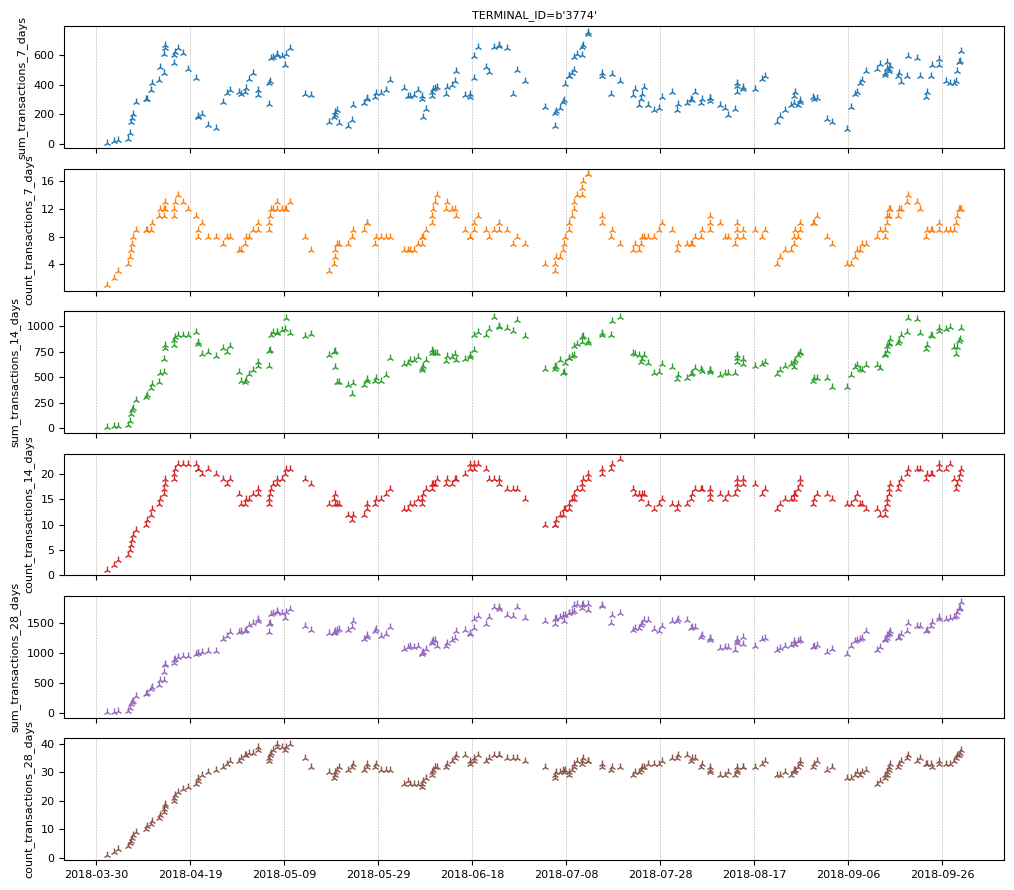

In [10]:
feature_set_1.plot(indexes="3774")

The banks knows if a transacation is fraudulent one week after it is made. We create a set of features that indicate the number and ratio of fraudulent transactions in the last N days.

In [11]:
# Lag the transactions by one week.
lagged_transactions = transactions_per_terminal.lag(tp.duration.weeks(1))

# Moving statistics per customer
tmp_features = []
for n in [7, 14, 28]:
    tmp_features.append(
        lagged_transactions["TX_FRAUD"]
        .moving_sum(tp.duration.days(n), sampling=transactions_per_terminal)
        .rename(f"count_fraud_transactions_{n}_days")
    )

    tmp_features.append(
        lagged_transactions["TX_FRAUD"]
        .cast(tp.float32)
        .simple_moving_average(tp.duration.days(n), sampling=transactions_per_terminal)
        .rename(f"rate_fraud_transactions_{n}_days")
    )

feature_set_2 = tp.glue(*tmp_features)

Transaction date and time can be correlated with fraud. While each transaction has a timestamp, a machine learning model might struggle to consume them directly. Instead, we extract various informative calendar features from the timestamps, such as hour, day of the week (e.g., Monday, Tuesday), and day of the month (1-31).

In [12]:
feature_set_3 = tp.glue(
    transactions_per_terminal.calendar_hour(),
    transactions_per_terminal.calendar_day_of_week(),
)

# Group together all the features and the label.
all_data = tp.glue(
    transactions_per_terminal, feature_set_1, feature_set_2, feature_set_3
).drop_index()

print("All the available features:")
all_data.schema.feature_names()


All the available features:


['CUSTOMER_ID',
 'TX_AMOUNT',
 'TX_FRAUD',
 'sum_transactions_7_days',
 'count_transactions_7_days',
 'sum_transactions_14_days',
 'count_transactions_14_days',
 'sum_transactions_28_days',
 'count_transactions_28_days',
 'count_fraud_transactions_7_days',
 'rate_fraud_transactions_7_days',
 'count_fraud_transactions_14_days',
 'rate_fraud_transactions_14_days',
 'count_fraud_transactions_28_days',
 'rate_fraud_transactions_28_days',
 'calendar_hour',
 'calendar_day_of_week',
 'TERMINAL_ID']

In [13]:
input_feature_names = [k for k in all_data.schema.feature_names() if k.islower()]

print("The model's input features:")
input_feature_names

The model's input features:


['sum_transactions_7_days',
 'count_transactions_7_days',
 'sum_transactions_14_days',
 'count_transactions_14_days',
 'sum_transactions_28_days',
 'count_transactions_28_days',
 'count_fraud_transactions_7_days',
 'rate_fraud_transactions_7_days',
 'count_fraud_transactions_14_days',
 'rate_fraud_transactions_14_days',
 'count_fraud_transactions_28_days',
 'rate_fraud_transactions_28_days',
 'calendar_hour',
 'calendar_day_of_week']

For neural networks to work correctly, numerical inputs must be normalized. A common approach is to apply z-normalization, which involves subtracting the mean and dividing by the standard deviation estimated from the training data to each value. In forecasting, such z-normalization is not recommended as it would lead to future leakage. Specifically, to classify a transaction at time t, we cannot rely on data after time t since, at serving time when making a prediction at time t, no subsequent data is available yet. In short, at time t, we are limited to using data that precedes or is concurrent with time t.

The solution is therefore to apply z-normalization over time, which means that we normalize each transaction using the mean and standard deviation computed from the past data for that transaction.

Future leakage is pernicious. Luckily, Temporian is here to help: the only operator that can cause future leakage is EventSet.leak(). If you are not using EventSet.leak(), your preprocessing is guaranteed not to create future leakage.

Note: For advanced pipelines, you can also check programatically that a feature does not depends on an EventSet.leak() operation.

In [14]:
# Cast all values (e.g. ints) to floats.
values = all_data[input_feature_names].cast(tp.float32)

# Apply z-normalization overtime.
normalized_features = (
    values - values.simple_moving_average(math.inf)
) / values.moving_standard_deviation(math.inf)

# Restore the original name of the features.
normalized_features = normalized_features.rename(values.schema.feature_names())

print(normalized_features)

indexes: []
features: [('sum_transactions_7_days', float32), ('count_transactions_7_days', float32), ('sum_transactions_14_days', float32), ('count_transactions_14_days', float32), ('sum_transactions_28_days', float32), ('count_transactions_28_days', float32), ('count_fraud_transactions_7_days', float32), ('rate_fraud_transactions_7_days', float32), ('count_fraud_transactions_14_days', float32), ('rate_fraud_transactions_14_days', float32), ('count_fraud_transactions_28_days', float32), ('rate_fraud_transactions_28_days', float32), ('calendar_hour', float32), ('calendar_day_of_week', float32)]
events:
     (1754155 events):
        timestamps: ['2018-04-01T00:00:31' '2018-04-01T00:02:10' '2018-04-01T00:07:56' ...
     '2018-09-30T23:58:21' '2018-09-30T23:59:52' '2018-09-30T23:59:57']
        'sum_transactions_7_days': [ 0.      1.      1.3636 ... -0.064  -0.2059  0.8428]
        'count_transactions_7_days': [   nan    nan    nan ... 1.0128 0.6892 1.66  ]
        'sum_transactions_14_da

/usr/local/lib/python3.10/dist-packages/temporian/implementation/numpy/operators/binary/arithmetic.py:100: RuntimeWarning: invalid value encountered in divide
  return evset_1_feature / evset_2_feature


In [15]:
normalized_features = normalized_features.fillna(0.0)
normalized_all_data = tp.glue(normalized_features, all_data["TX_FRAUD"])

Split dataset into a train, validation and test set
To evaluate the quality of our machine learning model, we need training, validation and test sets. Since the system is dynamic (new fraud patterns are being created all the time), it is important for the training set to come before the validation set, and the validation set come before the testing set:

Training: April 8, 2018 to July 31, 2018
Validation: August 1, 2018 to August 31, 2018
Testing: September 1, 2018 to September 30, 2018
For the example to run faster, we will effectively reduce the size of the training set to: - Training: July 1, 2018 to July 31, 2018

In [17]:
# begin_train = datetime.datetime(2018, 4, 8).timestamp() # Full training dataset
begin_train = datetime.datetime(2018, 7, 1).timestamp()  # Reduced training dataset
begin_valid = datetime.datetime(2018, 8, 1).timestamp()
begin_test = datetime.datetime(2018, 9, 1).timestamp()

is_train = (normalized_all_data.timestamps() >= begin_train) & (
    normalized_all_data.timestamps() < begin_valid
)
is_valid = (normalized_all_data.timestamps() >= begin_valid) & (
    normalized_all_data.timestamps() < begin_test
)
is_test = normalized_all_data.timestamps() >= begin_test

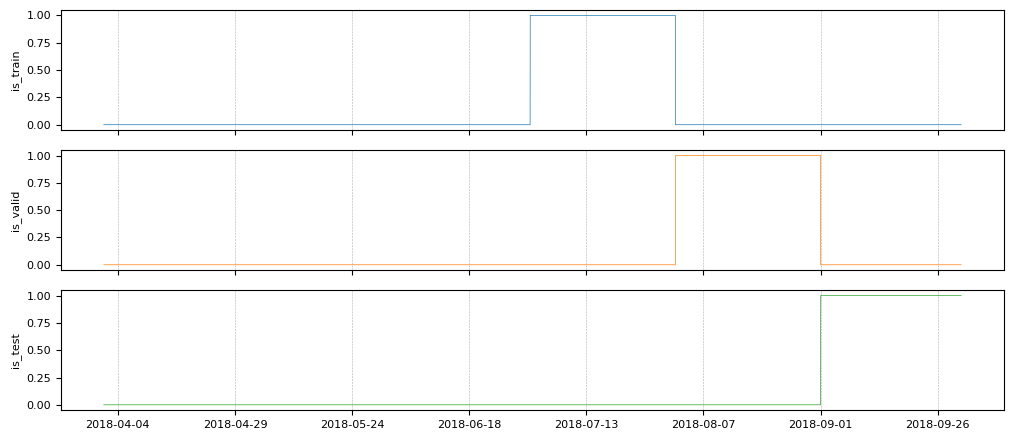

In [18]:
tp.plot(
    [
        is_train.rename("is_train"),
        is_valid.rename("is_valid"),
        is_test.rename("is_test"),
    ]
)

In [19]:
train_ds_evset = normalized_all_data.filter(is_train)
valid_ds_evset = normalized_all_data.filter(is_valid)
test_ds_evset = normalized_all_data.filter(is_test)

print(f"Training examples: {train_ds_evset.num_events()}")
print(f"Validation examples: {valid_ds_evset.num_events()}")
print(f"Testing examples: {test_ds_evset.num_events()}")

Training examples: 296928
Validation examples: 296559
Testing examples: 287873


It is important to split the dataset after the features have been computed because some of the features for the training dataset are computed from transactions during the training window.

## Create TensorFlow datasets
We convert the datasets from EventSets to TensorFlow Datasets as Keras consumes them natively.

In [20]:
non_batched_train_ds = tp.to_tensorflow_dataset(train_ds_evset)
non_batched_valid_ds = tp.to_tensorflow_dataset(valid_ds_evset)
non_batched_test_ds = tp.to_tensorflow_dataset(test_ds_evset)

The following processing steps are applied using TensorFlow datasets:

The features and labels are separated using extract_features_and_label in the format that Keras expects.
The dataset is batched, which means that the examples are grouped into mini-batches.
The training examples are shuffled to improve the quality of mini-batch training.
As we noted before, the dataset is imbalanced in the direction of legitimate transactions. While we want to evaluate our model on this original distribution, neural networks often train poorly on strongly imbalanced datasets. Therefore, we resample the training dataset to a ratio of 80% legitimate / 20% fraudulent using rejection_resample.

In [21]:
def extract_features_and_label(example):
    features = {k: example[k] for k in input_feature_names}
    labels = tf.cast(example["TX_FRAUD"], tf.int32)
    return features, labels


# Target ratio of fraudulent transactions in the training dataset.
target_rate = 0.2

# Number of examples in a mini-batch.
batch_size = 32

train_ds = (
    non_batched_train_ds.shuffle(10000)
    .rejection_resample(
        class_func=lambda x: tf.cast(x["TX_FRAUD"], tf.int32),
        target_dist=[1 - target_rate, target_rate],
        initial_dist=[1 - fraudulent_rate, fraudulent_rate],
    )
    .map(lambda _, x: x)  # Remove the label copy added by "rejection_resample".
    .batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)

# The test and validation dataset does not need resampling or shuffling.
valid_ds = (
    non_batched_valid_ds.batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    non_batched_test_ds.batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [22]:
for features, labels in train_ds.take(1):
    print("features")
    for feature_name, feature_value in features.items():
        print(f"\t{feature_name}: {feature_value[:4]}")
    print(f"labels: {labels[:4]}")

features
	sum_transactions_7_days: [-0.45657074  0.6086761  -0.7378138   2.6614287 ]
	count_transactions_7_days: [ 0.7199564   0.40184847 -0.23380977  2.3095298 ]
	sum_transactions_14_days: [-0.4116578  -0.00493402 -0.15246056  1.3900508 ]
	count_transactions_14_days: [ 0.38007423 -0.17445126  0.3802657   1.1185807 ]
	sum_transactions_28_days: [-0.07659125 -0.17270494 -0.3821308   1.9336714 ]
	count_transactions_28_days: [ 0.87521106 -0.25945124 -0.06919539  1.5357751 ]
	count_fraud_transactions_7_days: [-0.0977907  -0.09780496 -0.09775072 -0.09786063]
	rate_fraud_transactions_7_days: [-0.10947919 -0.1094934  -0.10945573 -0.10956173]
	count_fraud_transactions_14_days: [-0.10447286 -0.10451239 -0.10442241 -0.10455526]
	rate_fraud_transactions_14_days: [-0.11562728 -0.11564843 -0.11559068 -0.11569612]
	count_fraud_transactions_28_days: [-0.11286209 -0.11293823 -0.11281746 -0.11300741]
	rate_fraud_transactions_28_days: [-0.12632897 -0.12638023 -0.12631193 -0.12643148]
	calendar_hour: [ 0.

## Train the model
The original dataset is transactional, but the processed data is tabular and only contains normalized numerical values. Therefore, we train a feed-forward neural network.

In [26]:
inputs = [keras.Input(shape=(1,), name=name) for name in input_feature_names]
x = keras.layers.concatenate(inputs)
x = keras.layers.Dense(32, activation="relu")(x) # Changed activation function
x = keras.layers.Dense(16, activation="relu")(x) # Changed activation function
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=x)

#  Because the dataset is imbalanced, accuracy is not an informative metric. Instead, we evaluate the model using the area under the curve (AUC).

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.Accuracy(), keras.metrics.AUC()],
)
model.fit(train_ds, validation_data=valid_ds)

419/419 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.0000e+00 - auc_2: 0.6779 - loss: 0.5005 - val_accuracy: 0.0000e+00 - val_auc_2: 0.8148 - val_loss: 0.2845


In [28]:
model.evaluate(test_ds)

8997/8997 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.0000e+00 - auc_2: 0.8195 - loss: 0.2605


[0.2748391032218933, 0.0, 0.8137640953063965]

In [29]:
predictions = model.predict(test_ds)
predictions = np.nan_to_num(predictions, nan=0)

8997/8997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


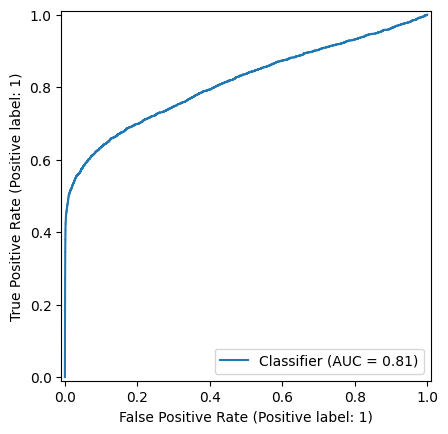

In [30]:
labels = np.concatenate([label for _, label in test_ds])
_ = RocCurveDisplay.from_predictions(labels, predictions)

In [32]:
model.save("fraud_detection_model.keras")

In [ ]:
# Later Reload
loaded_model = keras.saving.load_model("fraud_detection_model.keras")

# Generate predictions with the loaded model on 5 test examples.
loaded_model.predict(test_ds.rebatch(5).take(1))